In [1]:
#7.5.3. 从零实现
#下面，我们从头开始实现一个具有张量的批量归一化层。
!pip install d2l
import torch
from torch import nn
from d2l import torch as d2l

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过 `is_grad_enabled` 来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean)**2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean)**2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # 缩放和移位
    return Y, moving_mean.data, moving_var.data

     |████████████████████████████████| 81kB 2.1MB/s 


In [2]:
class BatchNorm(nn.Module):
    # `num_features`：完全连接层的输出数量或卷积层的输出通道数。
    # `num_dims`：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 如果 `X` 不在内存上，将 `moving_mean` 和 `moving_var`
        # 复制到 `X` 所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的 `moving_mean` 和 `moving_var`
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, self.moving_var,
            eps=1e-5, momentum=0.9)
        return Y

In [3]:
#7.5.4. 使用批量归一化层的 LeNet
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16,
                              kernel_size=5), BatchNorm(16, num_dims=4),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), nn.Linear(16 * 4 * 4, 120),
                    BatchNorm(120, num_dims=2), nn.Sigmoid(),
                    nn.Linear(120, 84), BatchNorm(84, num_dims=2),
                    nn.Sigmoid(), nn.Linear(84, 10))

loss 0.246, train acc 0.909, test acc 0.882
11755.7 examples/sec on cuda:0


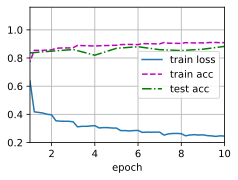

In [4]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [5]:
#让我们来看看从第一个批量归一化层中学到的拉伸参数 gamma 和偏移参数 beta。
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([2.2036, 1.7967, 2.4297, 2.2522, 1.4075, 2.0694], device='cuda:0',
        grad_fn=<ViewBackward>),
 tensor([-0.2199, -0.0092, -2.6774,  1.2570, -1.4778,  0.4336], device='cuda:0',
        grad_fn=<ViewBackward>))

In [6]:
#7.5.5. 简明实现
#除了使用我们刚刚定义的 BatchNorm ，我们也可以直接使用深度学习框架中定义的 BatchNorm 。 
#该代码看起来几乎与我们上面的代码相同。
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), nn.Linear(256, 120), nn.BatchNorm1d(120),
                    nn.Sigmoid(), nn.Linear(120, 84), nn.BatchNorm1d(84),
                    nn.Sigmoid(), nn.Linear(84, 10))

loss 0.248, train acc 0.909, test acc 0.843
21516.7 examples/sec on cuda:0


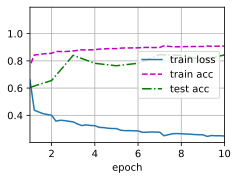

In [7]:
#下面，我们使用相同的超参数来训练我们的模型。 请注意，通常高级 API 变体运行速度快得多，
#因为它的代码已编译为 C++ 或 CUDA，而我们的自定义代码由 Python 实现。
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())